### Imports

In [138]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torchvision.datasets as dataset

from torch.optim import lr_scheduler
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np
import pandas as pd
import math
from pdb import set_trace
import shutil

import bcolz
import time
from utils import *
# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure
# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure
%matplotlib inline
import numpy as np
import cv2

In [139]:
import torch.optim as optim
from torchvision import datasets, models, transforms,utils
import time
import copy
plt.ion()   # interactive mode

In [140]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [141]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Sample 

In [142]:
path = 'data/montgomery_china_resized/' #path to 300x300 combined china and montgomery dataset

In [143]:
sample = cv2.imread(f'{path}train/normal/CHNCXR_0001_0.png',0)

A sample X-ray with no condition, single channel

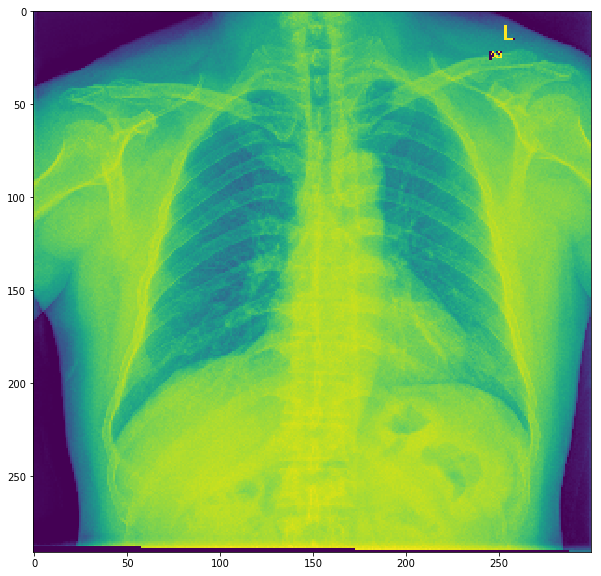

In [144]:
plt.figure(figsize=(10,10))
plt.imshow(sample)

In [145]:
sample.shape #input images are actually of size ~300 and all the 3 channels exactly the same

(291, 300)

Pixel intensity distribution of a sample normal X-ray images

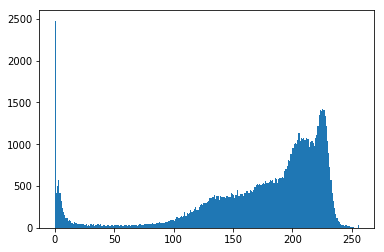

In [146]:
plt.hist(sample.ravel(),256,[0,256]); plt.show()

Distribution appears bimodal. Let's look at why there is a peak near zero

In [147]:
img = plt.imread('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

In [148]:
d = np.where(img<.1)

In [149]:
f = np.zeros(sample.shape)

In [150]:
for i,j in zip(list(d[0]),list(d[1])):
    f[i,j] = sample[i,j]

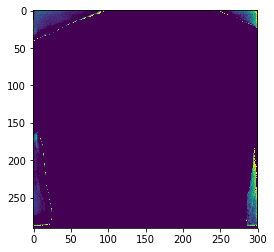

In [151]:
plt.imshow(f)

So the peak around 0 is mostly becasue of the noise in the corners of the X-ray

Now have a look at a sample image which has tuberculosis

In [152]:
sample_cond = cv2.imread(f'{path}train/condition/CHNCXR_0327_1.png',0)

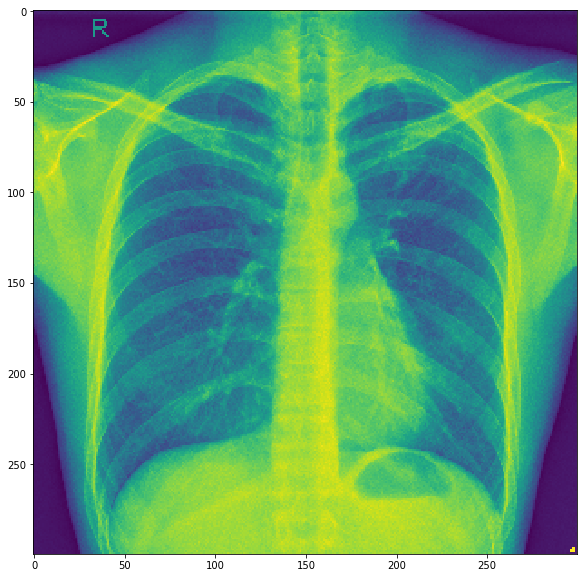

In [153]:
plt.figure(figsize=(10,10))
plt.imshow(sample_cond)

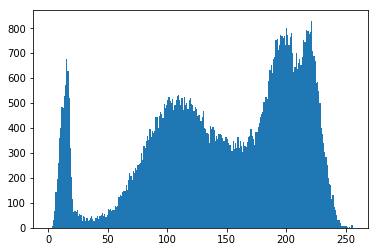

In [154]:
plt.hist(sample_cond.ravel(),256,[0,256]); plt.show()

### Histogram normalization

#### Histogram normalization

In [155]:
equ = cv2.equalizeHist(sample)
res = np.hstack((sample,equ)) #stacking images side-by-side

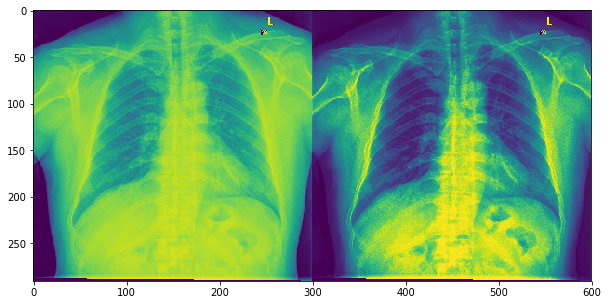

In [156]:
plt.figure(figsize=(10,10))
plt.imshow(res)

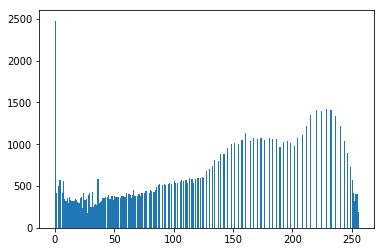

In [157]:
plt.hist(equ.ravel(),256,[0,256]); plt.show()

In [158]:
equ = cv2.equalizeHist(sample_cond)
res = np.hstack((sample_cond,equ)) #stacking images side-by-side

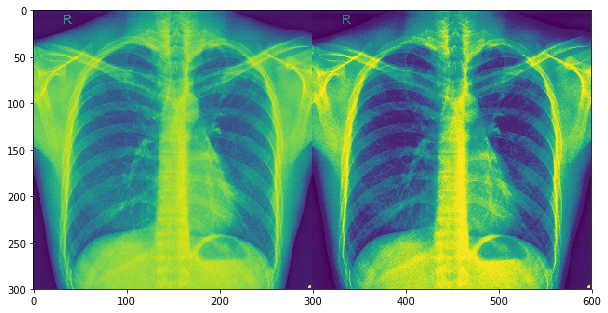

In [159]:
plt.figure(figsize=(10,10))
plt.imshow(res)

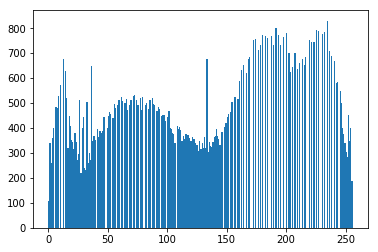

In [160]:
plt.hist(equ.ravel(),256,[0,256]); plt.show()

#### Contrast Limiting Adaptive histogram normalization

In [161]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
cl1 = clahe.apply(sample)
res = np.hstack((sample,cl1))

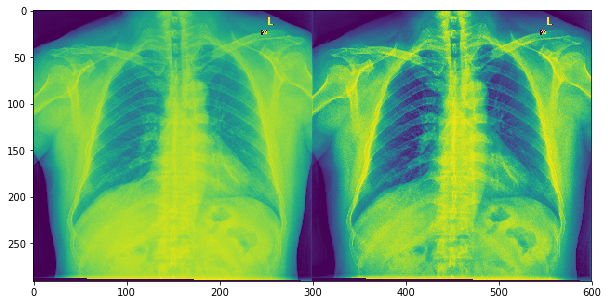

In [162]:
plt.figure(figsize=(10,10))
plt.imshow(res)

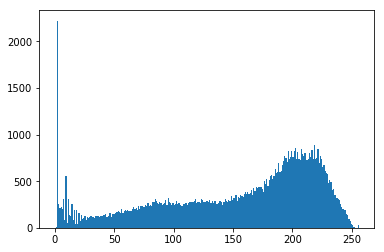

In [163]:
plt.hist(cl1.ravel(),256,[0,256]); plt.show()

In [164]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
cl1 = clahe.apply(sample_cond)
res = np.hstack((sample_cond,cl1))

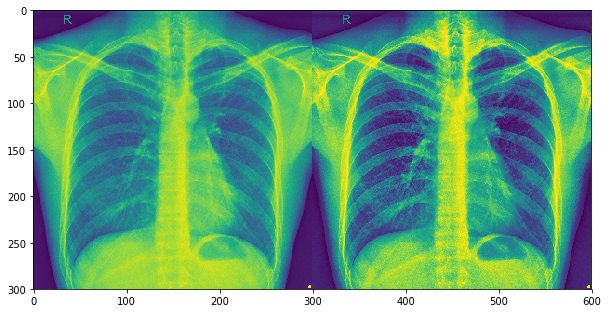

In [165]:
plt.figure(figsize=(10,10))
plt.imshow(res)

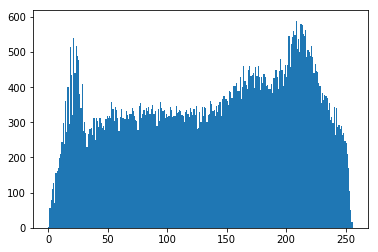

In [166]:
plt.hist(cl1.ravel(),256,[0,256]); plt.show()

We can see that both histogram and adaptive histogram equalization has improved the contrast. But the peak around 0 is still there. One possible option could be to crop the image to reduce the edges and then apply normalization

### Data pre-processing

In [167]:
sz =224 #we chose 224 as VGG-16 needs that size as input to the network

In [168]:
batch_size = 64

#### Defining transforms

In [169]:
#train transform
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(sz, scale=(.9,1)),
    transforms.RandomRotation(1),
    transforms.ToTensor() #normalization as same as Imagenet
])

#validation transform
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(sz, scale=(1,1)),
    transforms.ToTensor()
])

#### Dataloader

In [170]:
#training dataloader
traindir ='data/montgomery_china_resized_AHE_3_channel/train/'
train = dataset.ImageFolder(traindir, transform_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=6)

In [171]:
#for validation
valdir ='data/montgomery_china_resized_AHE_3_channel/valid/'
valid = dataset.ImageFolder(valdir, transform_valid)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False, num_workers=6)

In [172]:
dset_sizes = {'train': len(train.imgs), 'valid': len(valid.imgs)}
classes = train.classes

use_gpu = torch.cuda.is_available()

In [173]:
use_gpu #true if gpu is available

True

In [174]:
classes #condition indicates that x-ray has some signs of lung disease

['condition', 'normal']

In [175]:
dset_sizes #680 training images and 120 validation images

{'train': 680, 'valid': 120}

#### Testing the dataloader

In [176]:
xmb,ymb = next(iter(train_loader))

In [177]:
xmb.shape,ymb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [178]:
xmb,ymb = next(iter(valid_loader))

In [179]:
xmb.shape,ymb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

### VGG model

#### Downloading the model

In [180]:
model_vgg = models.vgg16(pretrained=True) #we are using VGG-16 model: this will download the weights for the model

In [181]:
model_vgg #this is how the architecture looks like

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

Now we have a pre-trained VGG network. VGG consist of 2 logical blocks: Convolution block and then Fully connected block. Now the idea of transfer learning is generally to train the last few layers to fine tune the model to capture the complex features and output the desired number of classes. As VGG-16 model was pre-trained on Imagenet competition which needs to output probabilities for 1000 classes, we need to modify the last layer so that it outputs 2 classes: 'normal', 'condition'. Let's try that...

#### Replacing the classifier layer completely and modifying the last layer

First we'll set the gradients for all the layers to be False to freeze them so that they become non trainable

In [182]:
for param in model_vgg.parameters():
    param.requires_grad = False #freezing the whole network, requires_grad = False makes the layers non-learnable

Let's look at the classifier section of the network

In [183]:
model_vgg.classifier #this is the FC block of the architecture   

Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000)
)

Copying the same layers with the last layer outputting 2 activations. Also as we are dropping the pre-trained weights for these layers.

In [184]:
model_vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 2))

In [185]:
model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=2)
)

Now make all the dense layers as learnable

In [186]:
for param in model_vgg.classifier.parameters():
    param.requires_grad = True

Shifting the model to gpu if available

In [187]:
if use_gpu:
    model_vgg = model_vgg.cuda()

Here we can see that only the last 6 layers are trainable

In [188]:
for param in model_vgg.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


### Training

In [189]:
criterion = nn.CrossEntropyLoss()
lr_start = 0.001
optimizer = torch.optim.Adam(model_vgg.classifier.parameters(),lr = lr_start,weight_decay=.001)
num_epochs = 20

#### Training and evaluation

In [190]:
%%time
train_loss_tracker = []
train_accuracy_tracker = []
val_loss_tracker = []
val_accuracy_tracker = []



for epoch in range(num_epochs):
    ## Training the model
    model_vgg.train(True) #Set model to training mode 
    print('------epoch{} started--------'.format(epoch))
    for i, (images, labels) in enumerate(train_loader, 0):
        images = Variable(images).cuda()  #for gpu
        labels = Variable(labels).cuda()  #for gpu

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, labels)
        train_loss_tracker.append(loss.data)
        loss.backward()
        optimizer.step()
        
        
        if (i + 1) % 5 == 0:
                avg_loss = np.mean(train_loss_tracker[-5:])
                print('Average training loss of last 5 mini-batches: %.4f' % (avg_loss))

    print('------epoch{} finished--------'.format(epoch))

    ## Prediction on training set for every epoch
    model_vgg.train(False)  #！！Set model to evaluation mode
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = Variable(images).cuda()
        outputs = model_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()  #labels type is torch.totensor; predicted is torch.cuda.totensor
    train_acc = 100 * correct / total
    train_accuracy_tracker.append(train_acc)
    print('Accuracy on training images %.4f' % (train_acc))
    

    ## Prediction on validation set for every epoch
    correct = 0
    total = 0
    running_loss = 0.0
    n = 0
    for images, labels in valid_loader:
        images = Variable(images).cuda()
        labels_t = Variable(labels).cuda()
        outputs = model_vgg(images) #for gpu
        
        loss = criterion(outputs, labels_t)
        val_loss_tracker.append(loss.data)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        images.cpu()
        labels_t.cpu()
    
    val_acc = 100 * correct / total
    val_accuracy_tracker.append(val_acc)
    val_loss_avg = np.mean(val_loss_tracker[-5:])
    
    print('Accuracy on validation images %.4f' % (val_acc))
    print('Average loss on validation images %.4f' % (val_loss_avg))

print('----Summary------')
print ('Best training accuracy: %.2f %%' % (max(train_accuracy_tracker))) 
print ('Best validation accuracy: %.2f %%' % (max(val_accuracy_tracker))) 
    
print('Finished Training')

------epoch0 started--------
Average training loss of last 5 mini-batches: 16.5975
Average training loss of last 5 mini-batches: 1.1766
------epoch0 finished--------
Accuracy on training images 50.8824
Accuracy on validation images 50.0000
Average loss on validation images 0.6909
------epoch1 started--------
Average training loss of last 5 mini-batches: 0.6489
Average training loss of last 5 mini-batches: 0.5160
------epoch1 finished--------
Accuracy on training images 81.4706
Accuracy on validation images 73.3333
Average loss on validation images 0.6025
------epoch2 started--------
Average training loss of last 5 mini-batches: 0.4581
Average training loss of last 5 mini-batches: 0.3997
------epoch2 finished--------
Accuracy on training images 86.3235
Accuracy on validation images 82.5000
Average loss on validation images 0.4708
------epoch3 started--------
Average training loss of last 5 mini-batches: 0.3501
Average training loss of last 5 mini-batches: 0.3927
------epoch3 finished---

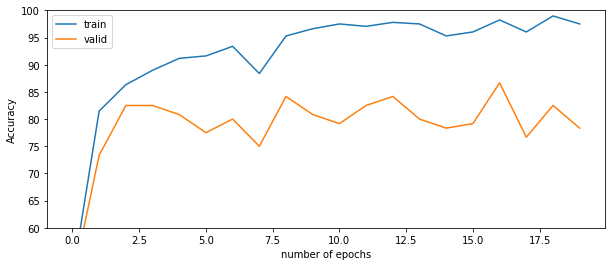

In [191]:
plt.figure(figsize=(10,4))
plt.plot(train_accuracy_tracker, label = 'train')
plt.plot(val_accuracy_tracker, label = 'valid')
plt.plot(val_loss_avg)
plt.legend(loc = 'upper left')
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
axes = plt.gca()
axes.set_ylim([60,100])
plt.show()

#### Prediction

In [192]:
def predict(model, dataloader,is_train=True):
    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    val_loss = []
    if is_train:
        #for train
        for images, labels in dataloader:
            images = Variable(images).cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum()
        accuracy = 100 * correct / total
        return accuracy
    else:
        #for validation
        for images, labels in dataloader:
            images = Variable(images).cuda()
            labels_t = Variable(labels).cuda()
            outputs = model(images)
            loss = criterion(outputs, labels_t)
            val_loss.append(loss.data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum()
            images.cpu()
            labels_t.cpu()
        accuracy = 100 * correct / total
        val_loss_avg = np.mean(val_loss)        
        return accuracy,val_loss_avg 

Accuracy on training images

In [193]:
predict(model_vgg,train_loader)

96.61764705882354

Accuracy on validation images

In [200]:
predict(model_vgg,valid_loader,False)

(78.33333333333333, 0.7047603)

In [195]:
def save_checkpoint(state,filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    shutil.copyfile(filename, 'model_best.pth.tar')

In [197]:
torch.save(model_vgg,'best_model')

In [198]:
m = torch.load('best_model')

In [205]:
predict(m,train_loader)

96.61764705882354

### Visualizing CNNs

In [210]:
model_vgg.eval() #shifting to evaluation mode

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

#### Activations from each layer and filter

In [307]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

In [ ]:
train_loader_bs1 = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True, num_workers=6) #Modifying the dataloader to pass only one image

In [423]:
xmb,ymb =  next(iter(train_loader_bs1)) #storing a mini-batch

In [424]:
xmb[0].shape

torch.Size([3, 224, 224])

In [425]:
x = Variable(xmb).cuda() #shifting it to cuda

In [355]:
#Getting activations from filter 0 from each layer
activation_dict = {}
for index, layer in enumerate(model_vgg.features):
    x = layer(x)
    a = x.data.cpu().numpy()
    activation_dict[index] = a[0, 0]

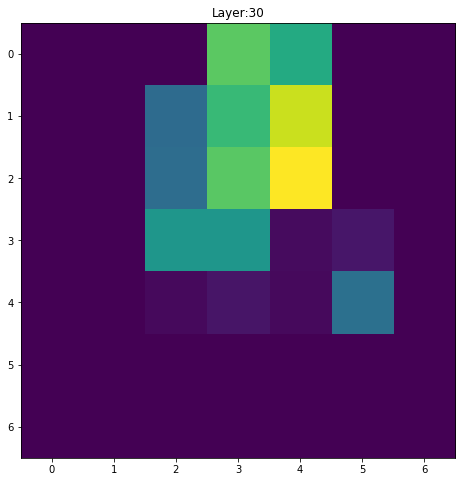

In [548]:
layer_num = 30
plt.figure(figsize=(8,8))
plt.title("Layer:"+str(layer_num))
plt.imshow(activation_dict[layer_num])

In [326]:
# #for getting activations from a certai layers
# index = 10
# for i, layer in enumerate(model_vgg.features):
#     x = layer(x)
#     if i == index:
#         a = x.data.cpu().numpy()
#         break

#### Image patch that maximes filter

In [388]:
def conv_single_step(a_slice_prev, W):
    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = a_slice_prev*W
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    return Z

In [442]:
l1 = model_vgg.features[0]

In [525]:
f1 = l1.weight.data[1]

In [526]:
f1


(0 ,.,.) = 
  0.2325  0.1267  0.1861
 -0.4281 -0.2435  0.2463
 -0.2507  0.1418 -0.0055

(1 ,.,.) = 
 -0.1408 -0.2190  0.1504
 -0.8413 -0.3518  0.5640
 -0.2419  0.5193  0.5391

(2 ,.,.) = 
 -0.3143 -0.3705 -0.1309
 -0.4714 -0.1550  0.3459
  0.0544  0.5868  0.4958
[torch.cuda.FloatTensor of size 3x3x3 (GPU 0)]

In [527]:
f1 = f1.cpu().numpy()

In [528]:
f1

array([[[ 0.23254,  0.12666,  0.18605],
        [-0.42805, -0.24349,  0.24628],
        [-0.25066,  0.14177, -0.00549]],

       [[-0.14076, -0.21903,  0.15041],
        [-0.84127, -0.35176,  0.56398],
        [-0.24194,  0.51928,  0.53915]],

       [[-0.31432, -0.37048, -0.13094],
        [-0.47144, -0.15503,  0.34589],
        [ 0.05438,  0.58683,  0.4958 ]]], dtype=float32)

In [529]:
f1.shape

(3, 3, 3)

In [530]:
img = x[0].data.cpu().numpy()

In [531]:
img.shape

(3, 224, 224)

In [532]:
img_pad = np.pad(img,((0,0), (1,1), (1,1)),mode = 'constant')

In [533]:
img_pad.shape

(3, 226, 226)

In [534]:
stride = 1
f = 3
pad= 1

In [535]:
n_H = int(1+(224+2*pad-f)/stride)
n_W = int(1+(224+2*pad-f)/stride)

In [536]:
activation = []

In [537]:
activation_track = []

In [538]:
i=0
for h in range(0,n_H):                           # loop over vertical axis of the output volume
    for w in range(0,n_W):                       # loop over horizontal axis of the output volume
            # Find the corners of the current "slice" (≈4 lines)
            vert_start = stride*h
            vert_end = stride*h+f
            horiz_start = stride*w
            horiz_end = stride*w+f


            # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
            a_slice_prev = img_pad[:,vert_start:vert_end,horiz_start:horiz_end]
            activation_track.append(conv_single_step(a_slice_prev, f1))
            # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
            activation.append((a_slice_prev,conv_single_step(a_slice_prev, f1)))


In [539]:
activation_track.index(np.max(activation_track))

13889

In [540]:
f1

array([[[ 0.23254,  0.12666,  0.18605],
        [-0.42805, -0.24349,  0.24628],
        [-0.25066,  0.14177, -0.00549]],

       [[-0.14076, -0.21903,  0.15041],
        [-0.84127, -0.35176,  0.56398],
        [-0.24194,  0.51928,  0.53915]],

       [[-0.31432, -0.37048, -0.13094],
        [-0.47144, -0.15503,  0.34589],
        [ 0.05438,  0.58683,  0.4958 ]]], dtype=float32)

In [541]:
activation[13889][0].shape

(3, 3, 3)

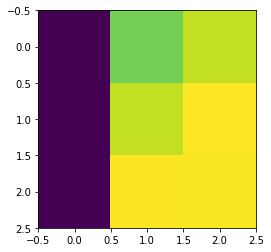

In [544]:
plt.imshow(activation[13889][0][1])

### Precompute the activations

As we are only training part of the model, essentially only the last layer, we might as well precompute the activate and save it so that for each run of gradient descent we don't have to calculate the forward pass as till the last layer it'll be the same. For now we are precomputing the convolution block

In [ ]:
def precompute(dataloader):
    conv_activations = []
    labels_list = []
    for i, (images, labels) in enumerate(dataloader):
        if use_gpu:
            images, labels = Variable(images.cuda()), Variable(
                labels.cuda())  #shifting to gpu

        activations = model_vgg.features(
            images)  #applying conv block on the batch of images

        #shifting to cpu and storing to numpy
        conv_activations.extend(activations.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())

    #for all batches
    conv_activations = np.concatenate(
        [[activation] for activation in conv_activations])

    return (conv_activations, labels_list)

In [ ]:
trn_pc_act,trn_lbl = precompute(train_loader) #precompute for train

In [ ]:
trn_pc_act.shape #number of images x channels x height x width

In [ ]:
len(trn_lbl)

In [ ]:
val_pc_act,val_lbl = precompute(valid_loader) #precompute for valid

In [ ]:
val_pc_act.shape #number of images x channels x height x width

In [ ]:
len(val_lbl)

#### Data generator

In [ ]:
np.random.permutation(10)

In [ ]:
len(trn_pc_act)

In [ ]:
def data_generator(conv_activations, labels, batch_size=64, shuffle=True):
#     set_trace()
    labels = np.array(labels)
    if shuffle:
        idx = np.random.permutation(len(conv_activations))
        conv_activations = conv_activations[idx]  #this will shuffle the features
        labels = labels[idx]  #follow the same indexing for the labels

    for i in range(0, len(conv_activations), batch_size):
        yield (conv_activations[i:i + batch_size], labels[i:i + batch_size])